In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='pastel', font='serif')
sns.set_style('white')

In [2]:
# Define functions
def studentpdf(epsilon, nu):
    # if nu <= 2: 
    #     return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)


def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared


def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu)
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared


def asymmetric_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, kappa_tilde, nu = parameters
    T = len(returns)
    
    u = np.zeros(T)
    v = np.zeros(T)
    epsilon = np.zeros(T)
    lambdas = np.zeros(T)
    sigma = np.zeros(T)
    
    # Initialize starting values
    lambdas[0] = lam
    sigma[0] = np.exp(lam)
    epsilon[0] = (returns[0] - mu) / sigma[0]
    u[0] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]**2 - 1)
    v[0] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]
    
    for t in range(1, T):
        lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
        sigma[t] = np.exp(lambdas[t])
        epsilon[t] = (returns[t] - mu) / sigma[t]
        u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
        v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
    
    return sigma**2, u, v

def negative_log_likelihood(parameters, returns, model_type):
    """negative log-likelihood function"""
    mu = parameters[0]
    nu = parameters[-1]
    if model_type == 'GARCH':
        omega, alpha, beta = parameters[1:-1]
        sigma_squared = garch(mu, omega, alpha, beta, returns)
    elif model_type == 'Asymmetric GARCH':
        omega, alpha_pos, alpha_neg, beta = parameters[1:-1]
        sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    elif model_type == 'Asymmetric Beta-t-EGARCH' or 'Symmetric Beta-t-EGARCH':
        lam, phi, kappa, k_tilde = parameters[1:-1]
        sigma_squared, _, _ = asymmetric_beta_t_egarch(parameters, returns)
    else:
        raise ValueError("Invalid model type")
    
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)


def optimize_model(model_type, initial_values, bounds, returns):
    """optimization function for different volatility models."""
    result = optimize.minimize(negative_log_likelihood, initial_values, args=(returns, model_type), bounds=bounds, method='Nelder-Mead')
    return result


def plot_results(dates, returns, sigma_squared, model_name):
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(dates, returns, 'k', label='Returns')
    plt.plot(dates, np.sqrt(sigma_squared), label=f'Estimated $\hat{{\sigma}}_{{t|t-1}}$ from {model_name} model')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Returns and Estimated Volatility - {model_name}')
    plt.show()
    

def plot_nic(epsilon, nic, model_name):
    plt.figure(figsize=(10, 5), dpi=300)
    plt.scatter(epsilon, nic, alpha=0.7)
    plt.xlabel('Implied residual $\epsilon_t$')
    plt.ylabel('NIC')
    plt.title(f'News Impact Curve of the {model_name}')
    sns.despine()
    plt.show()

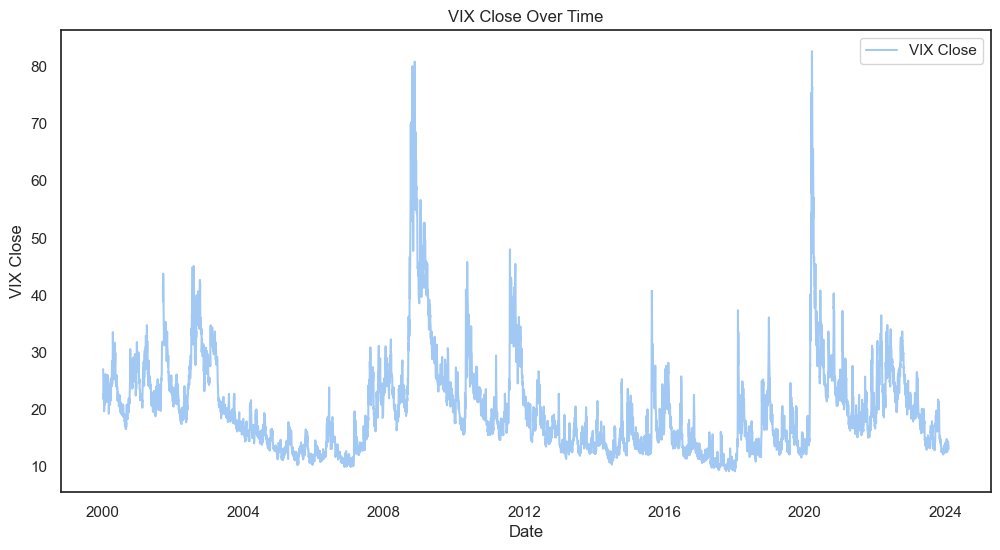

In [3]:
# Read data
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()


# Symmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:71: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:72: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


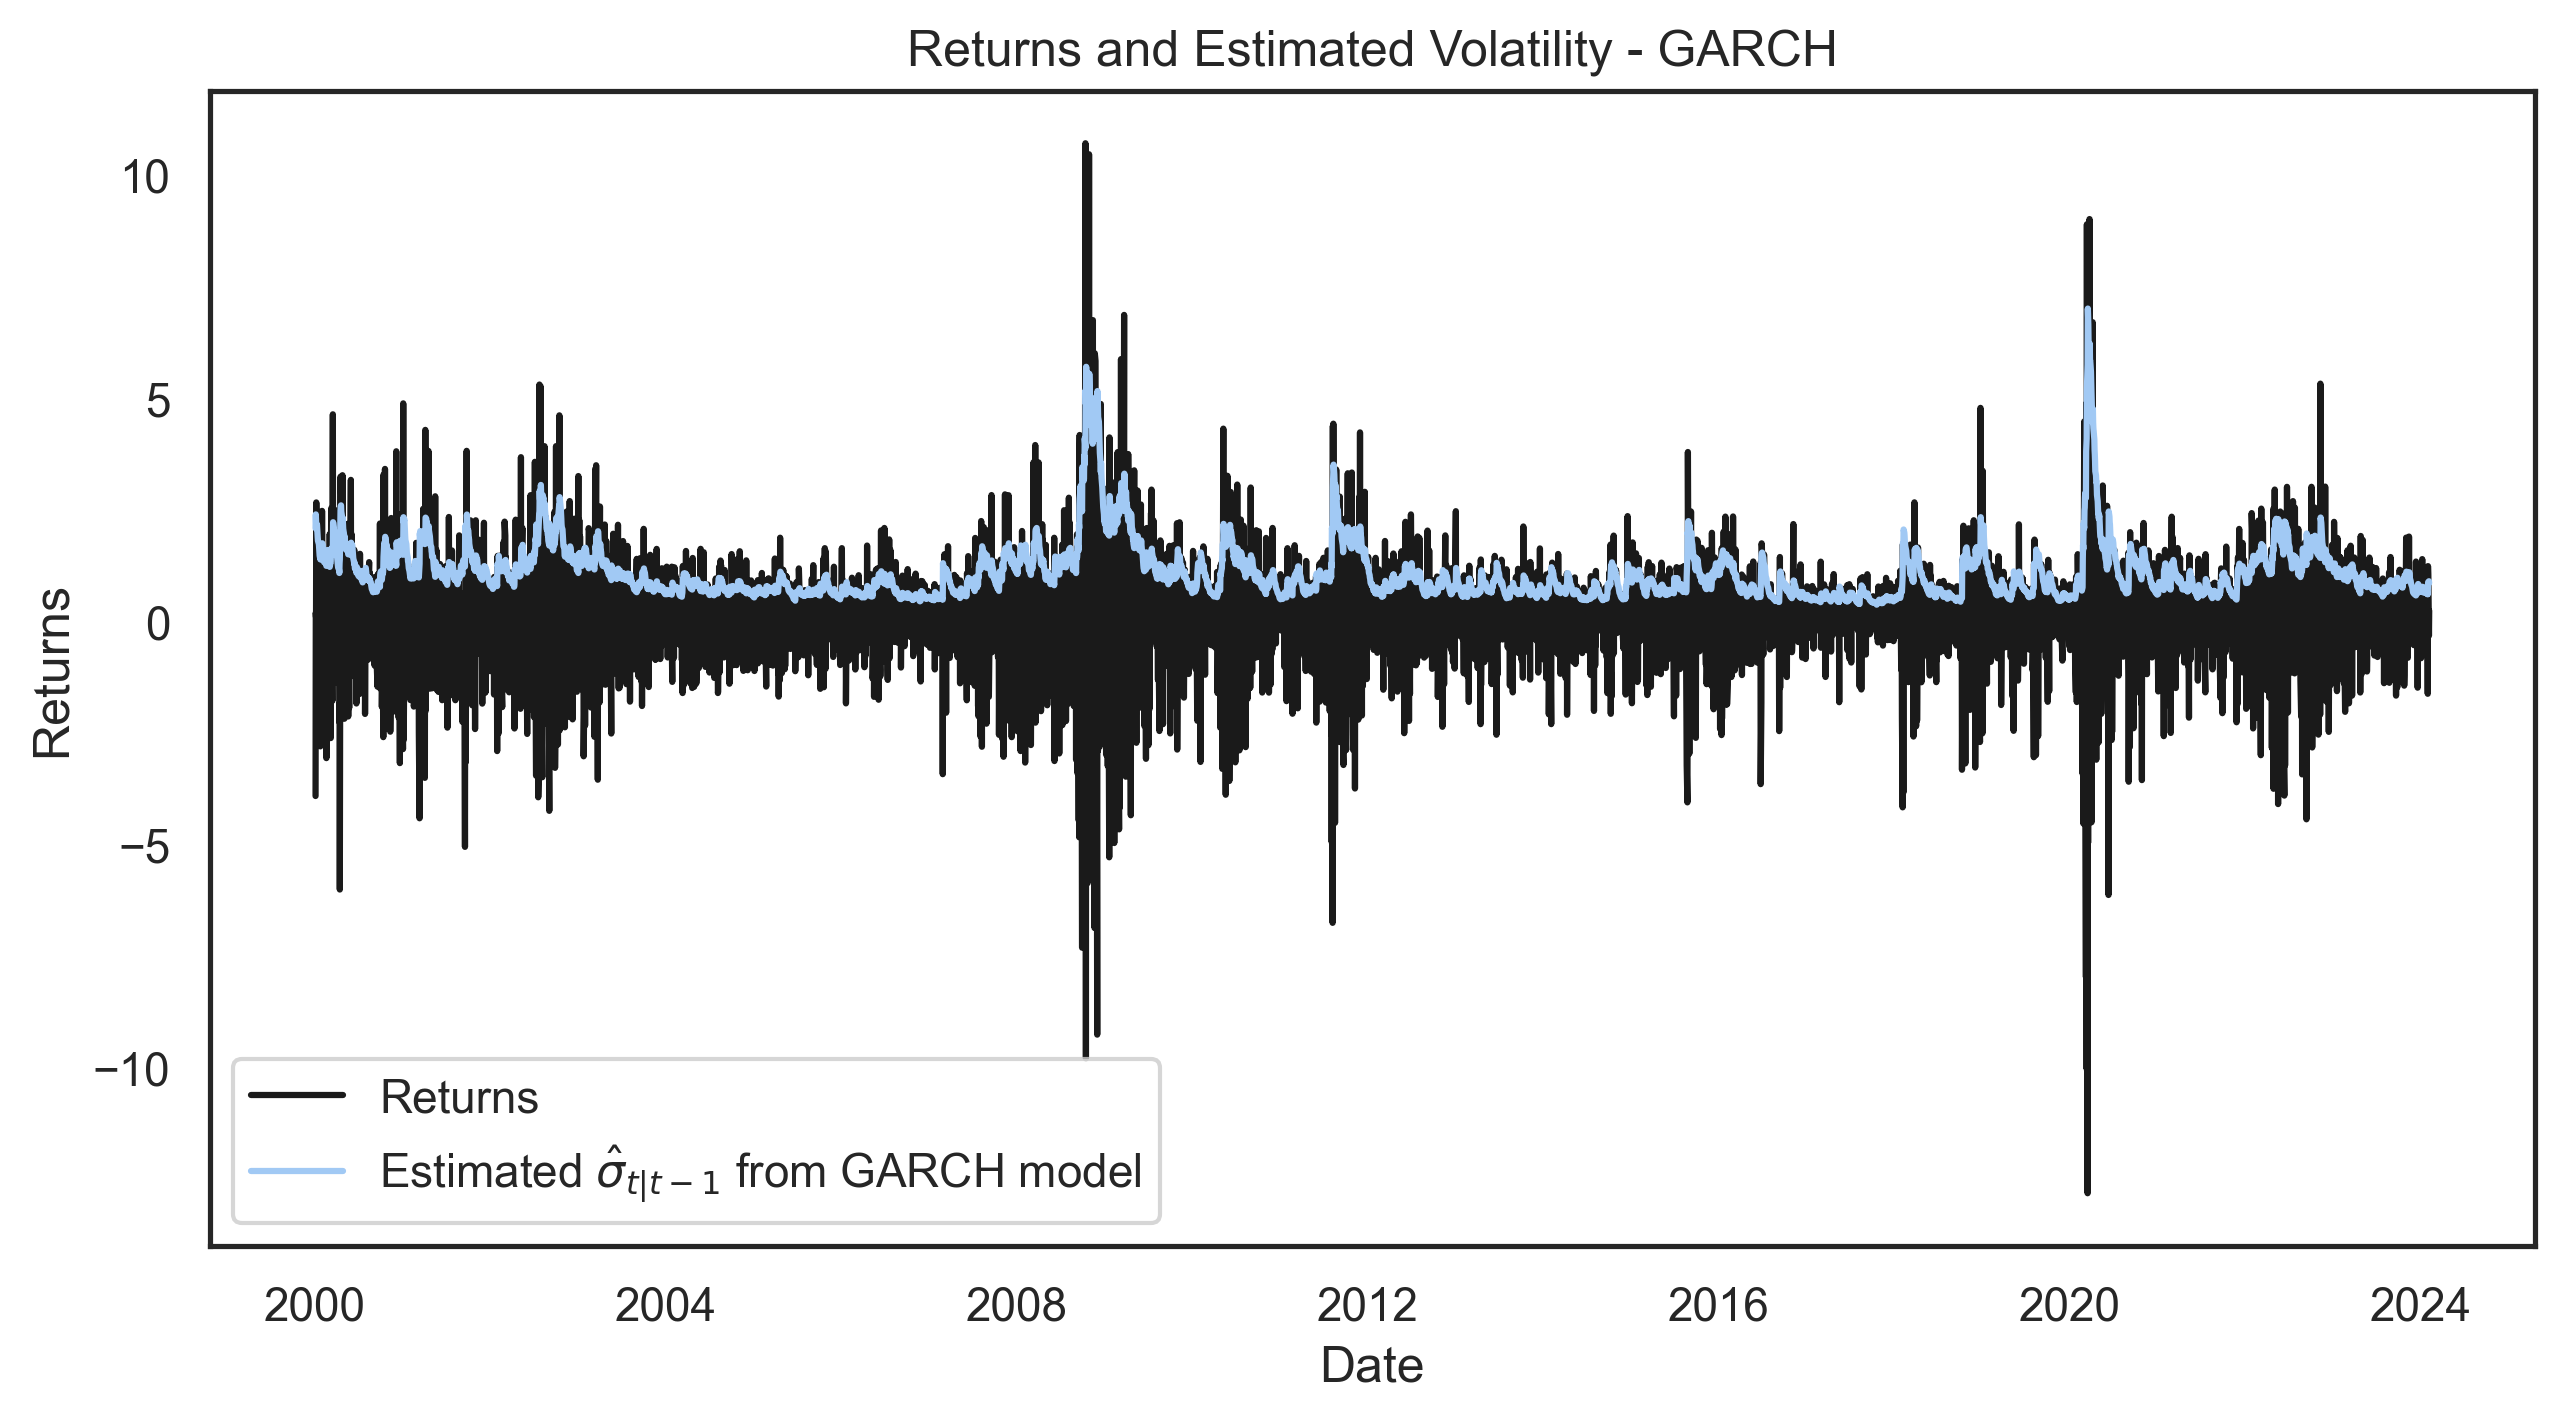

Optimization Successful: Yes
Estimated Parameters:
  mu    : 0.076
  omega : 0.013
  alpha : 0.121
  beta  : 0.876
  nu    : 6.470
Log-Likelihood: -8211.3


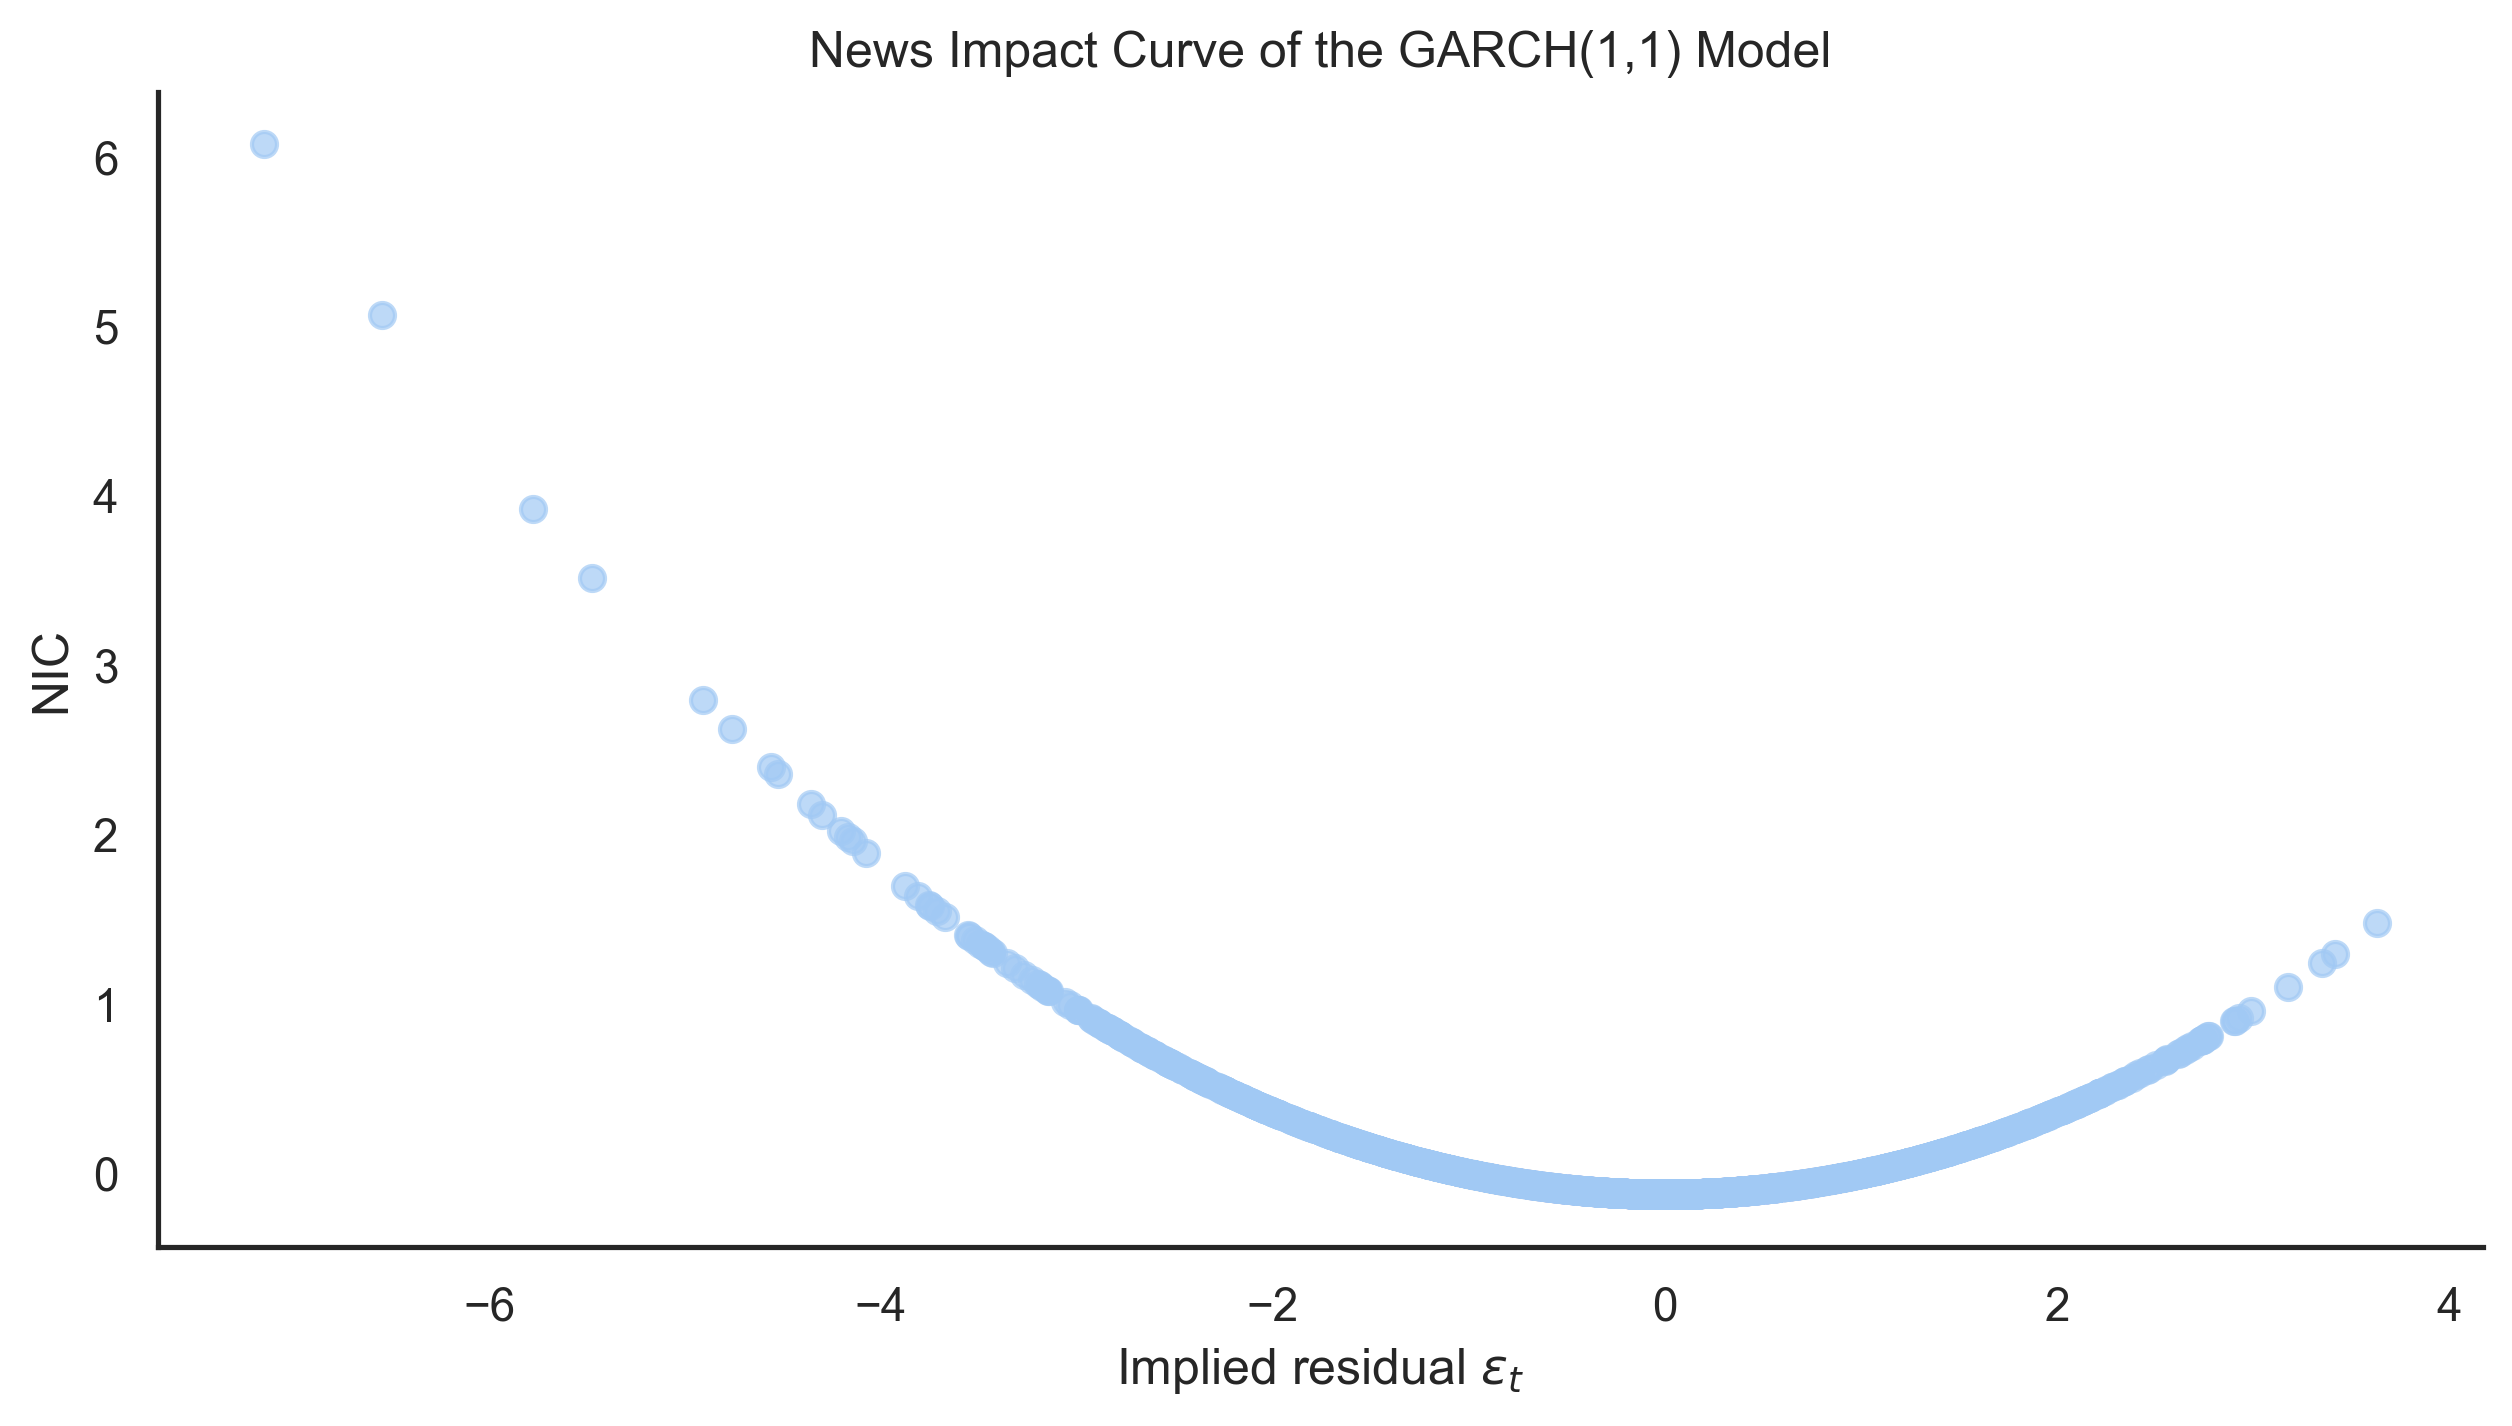

In [4]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

plot_results(dates, returns, sigma_squared, 'GARCH')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu    : {mu_hat:.3f}")
print(f"  omega : {omega_hat:.3f}")
print(f"  alpha : {alpha_hat:.3f}")
print(f"  beta  : {beta_hat:.3f}")
print(f"  nu    : {nu_hat:.3f}")

print(f"Log-Likelihood: {log_likelihood:.1f}")

conditional_var = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'GARCH(1,1) Model')

# Asymmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:71: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:72: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


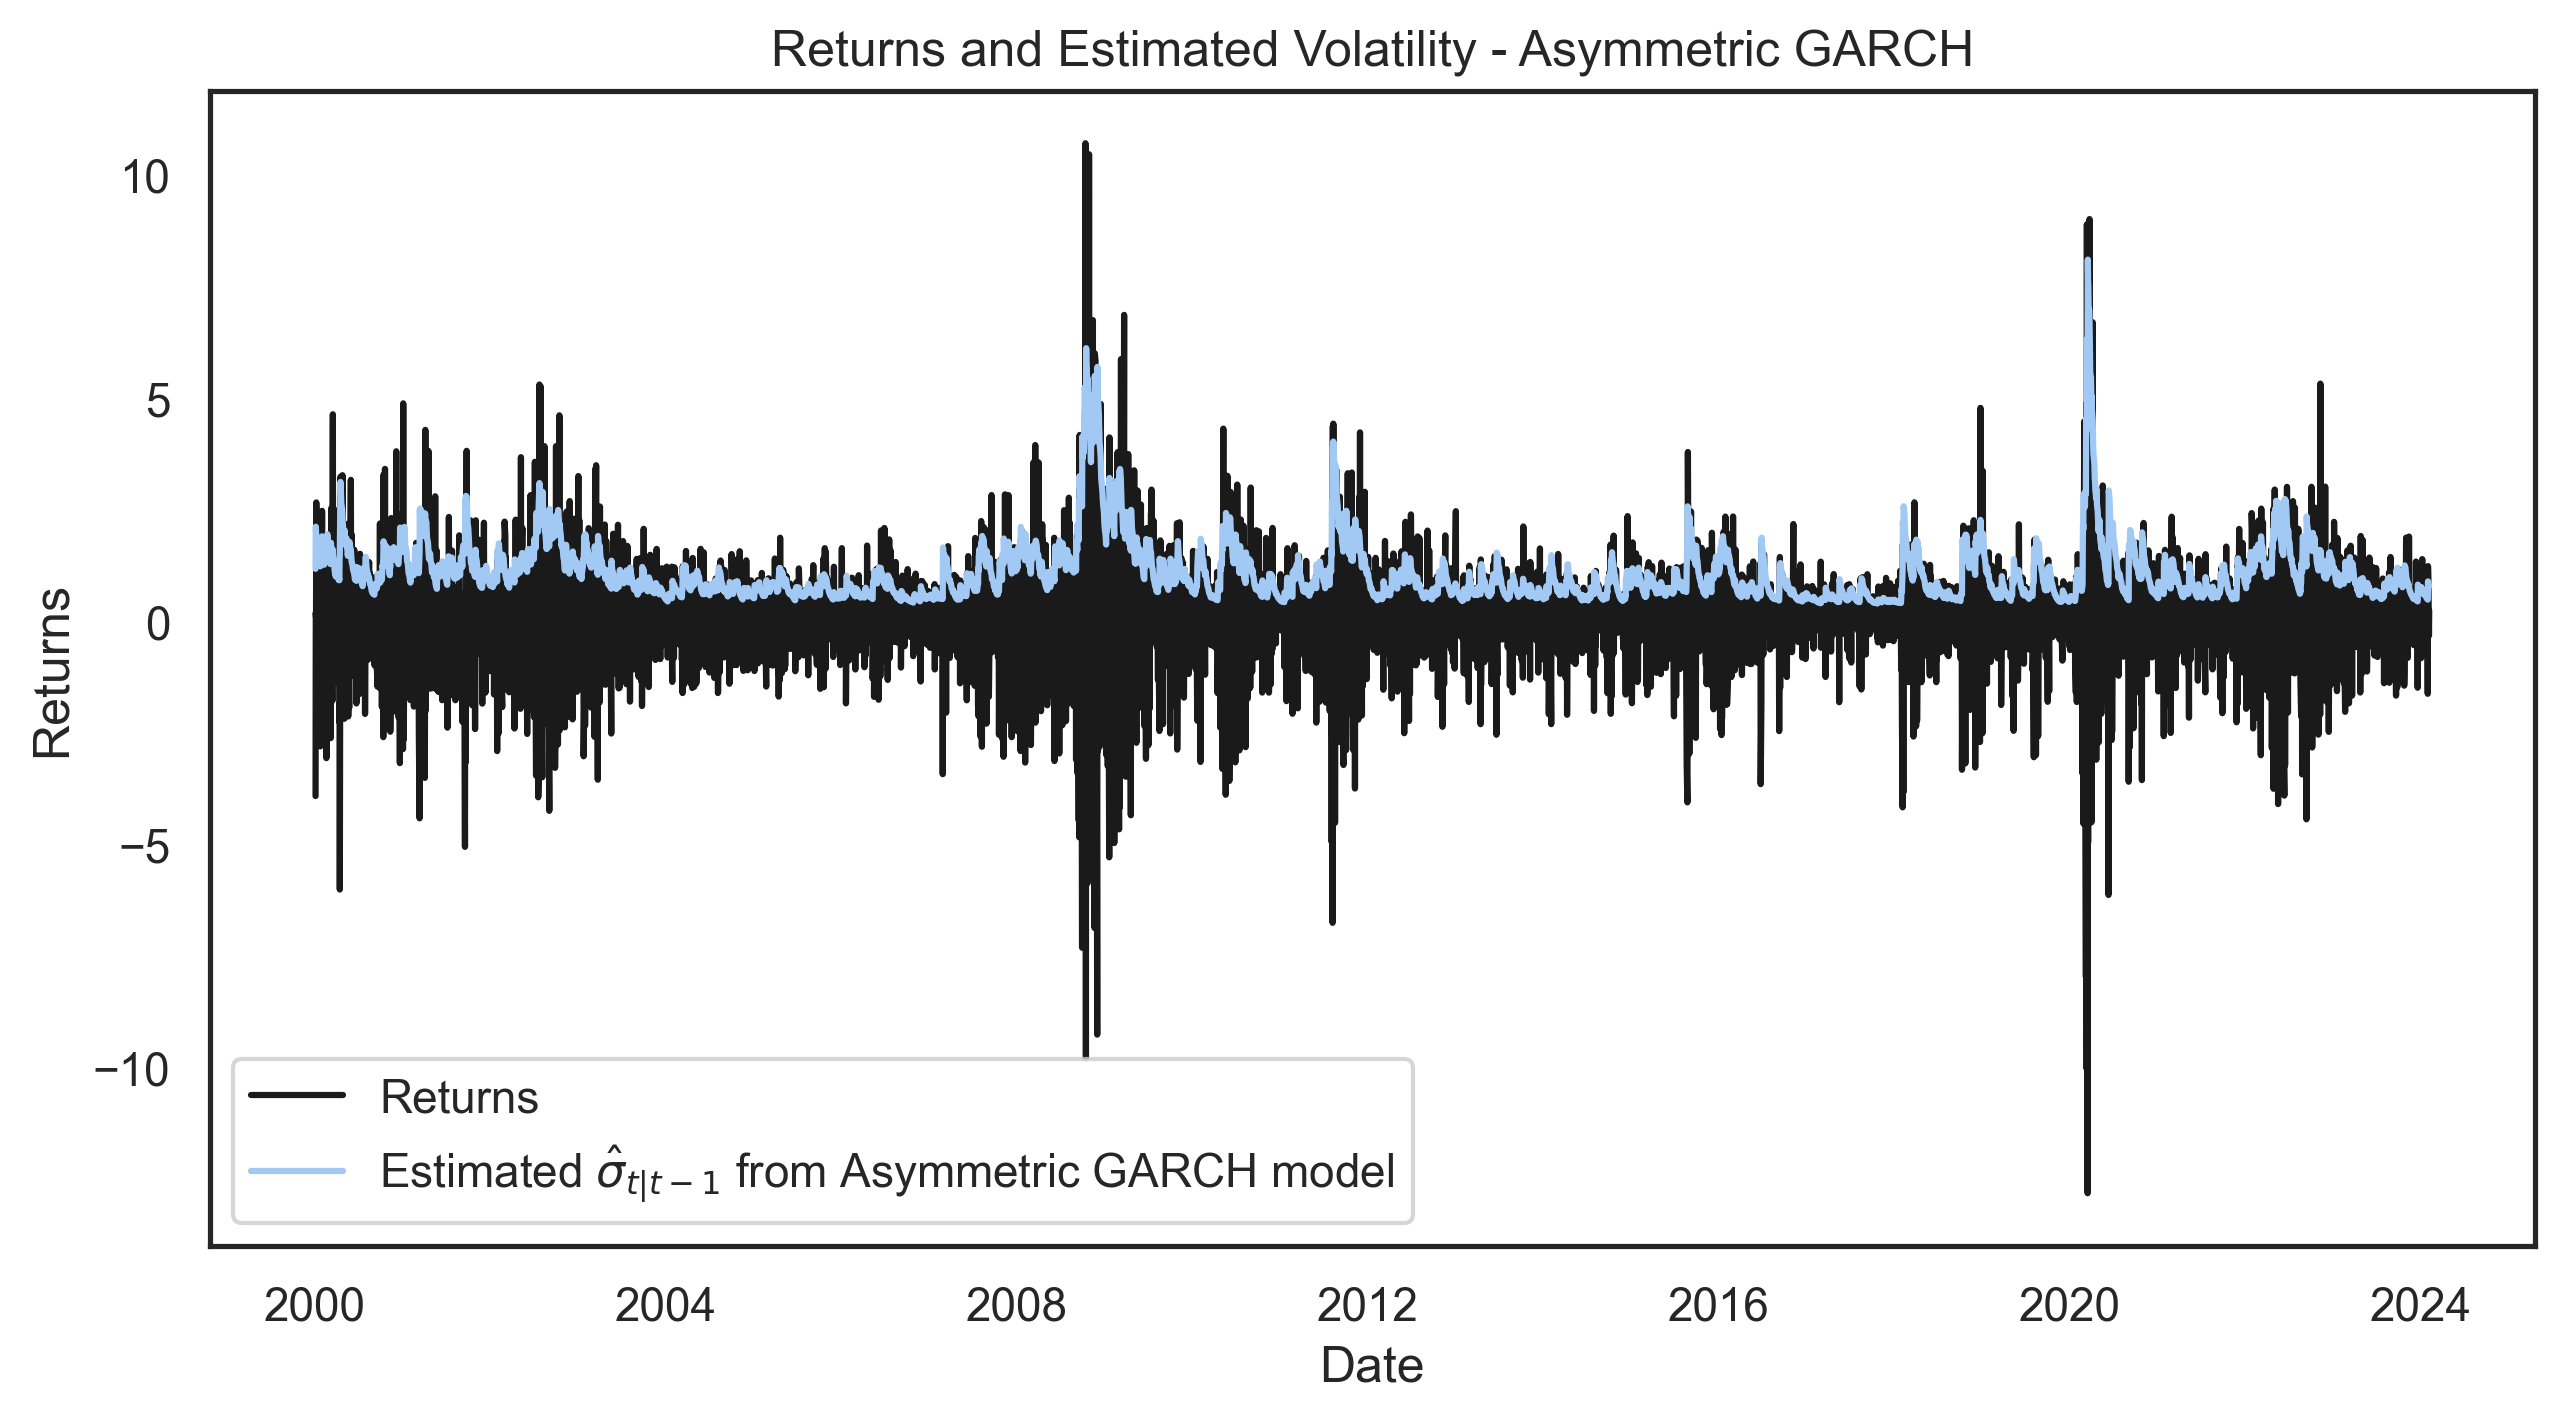

Optimization Successful: Yes
Estimated Parameters:
  mu          : 0.046
  omega       : 0.017
  alpha_pos   : 0.000
  alpha_neg   : 0.208
  beta        : 0.884
  nu          : 6.892
Log-Likelihood: -8111.4


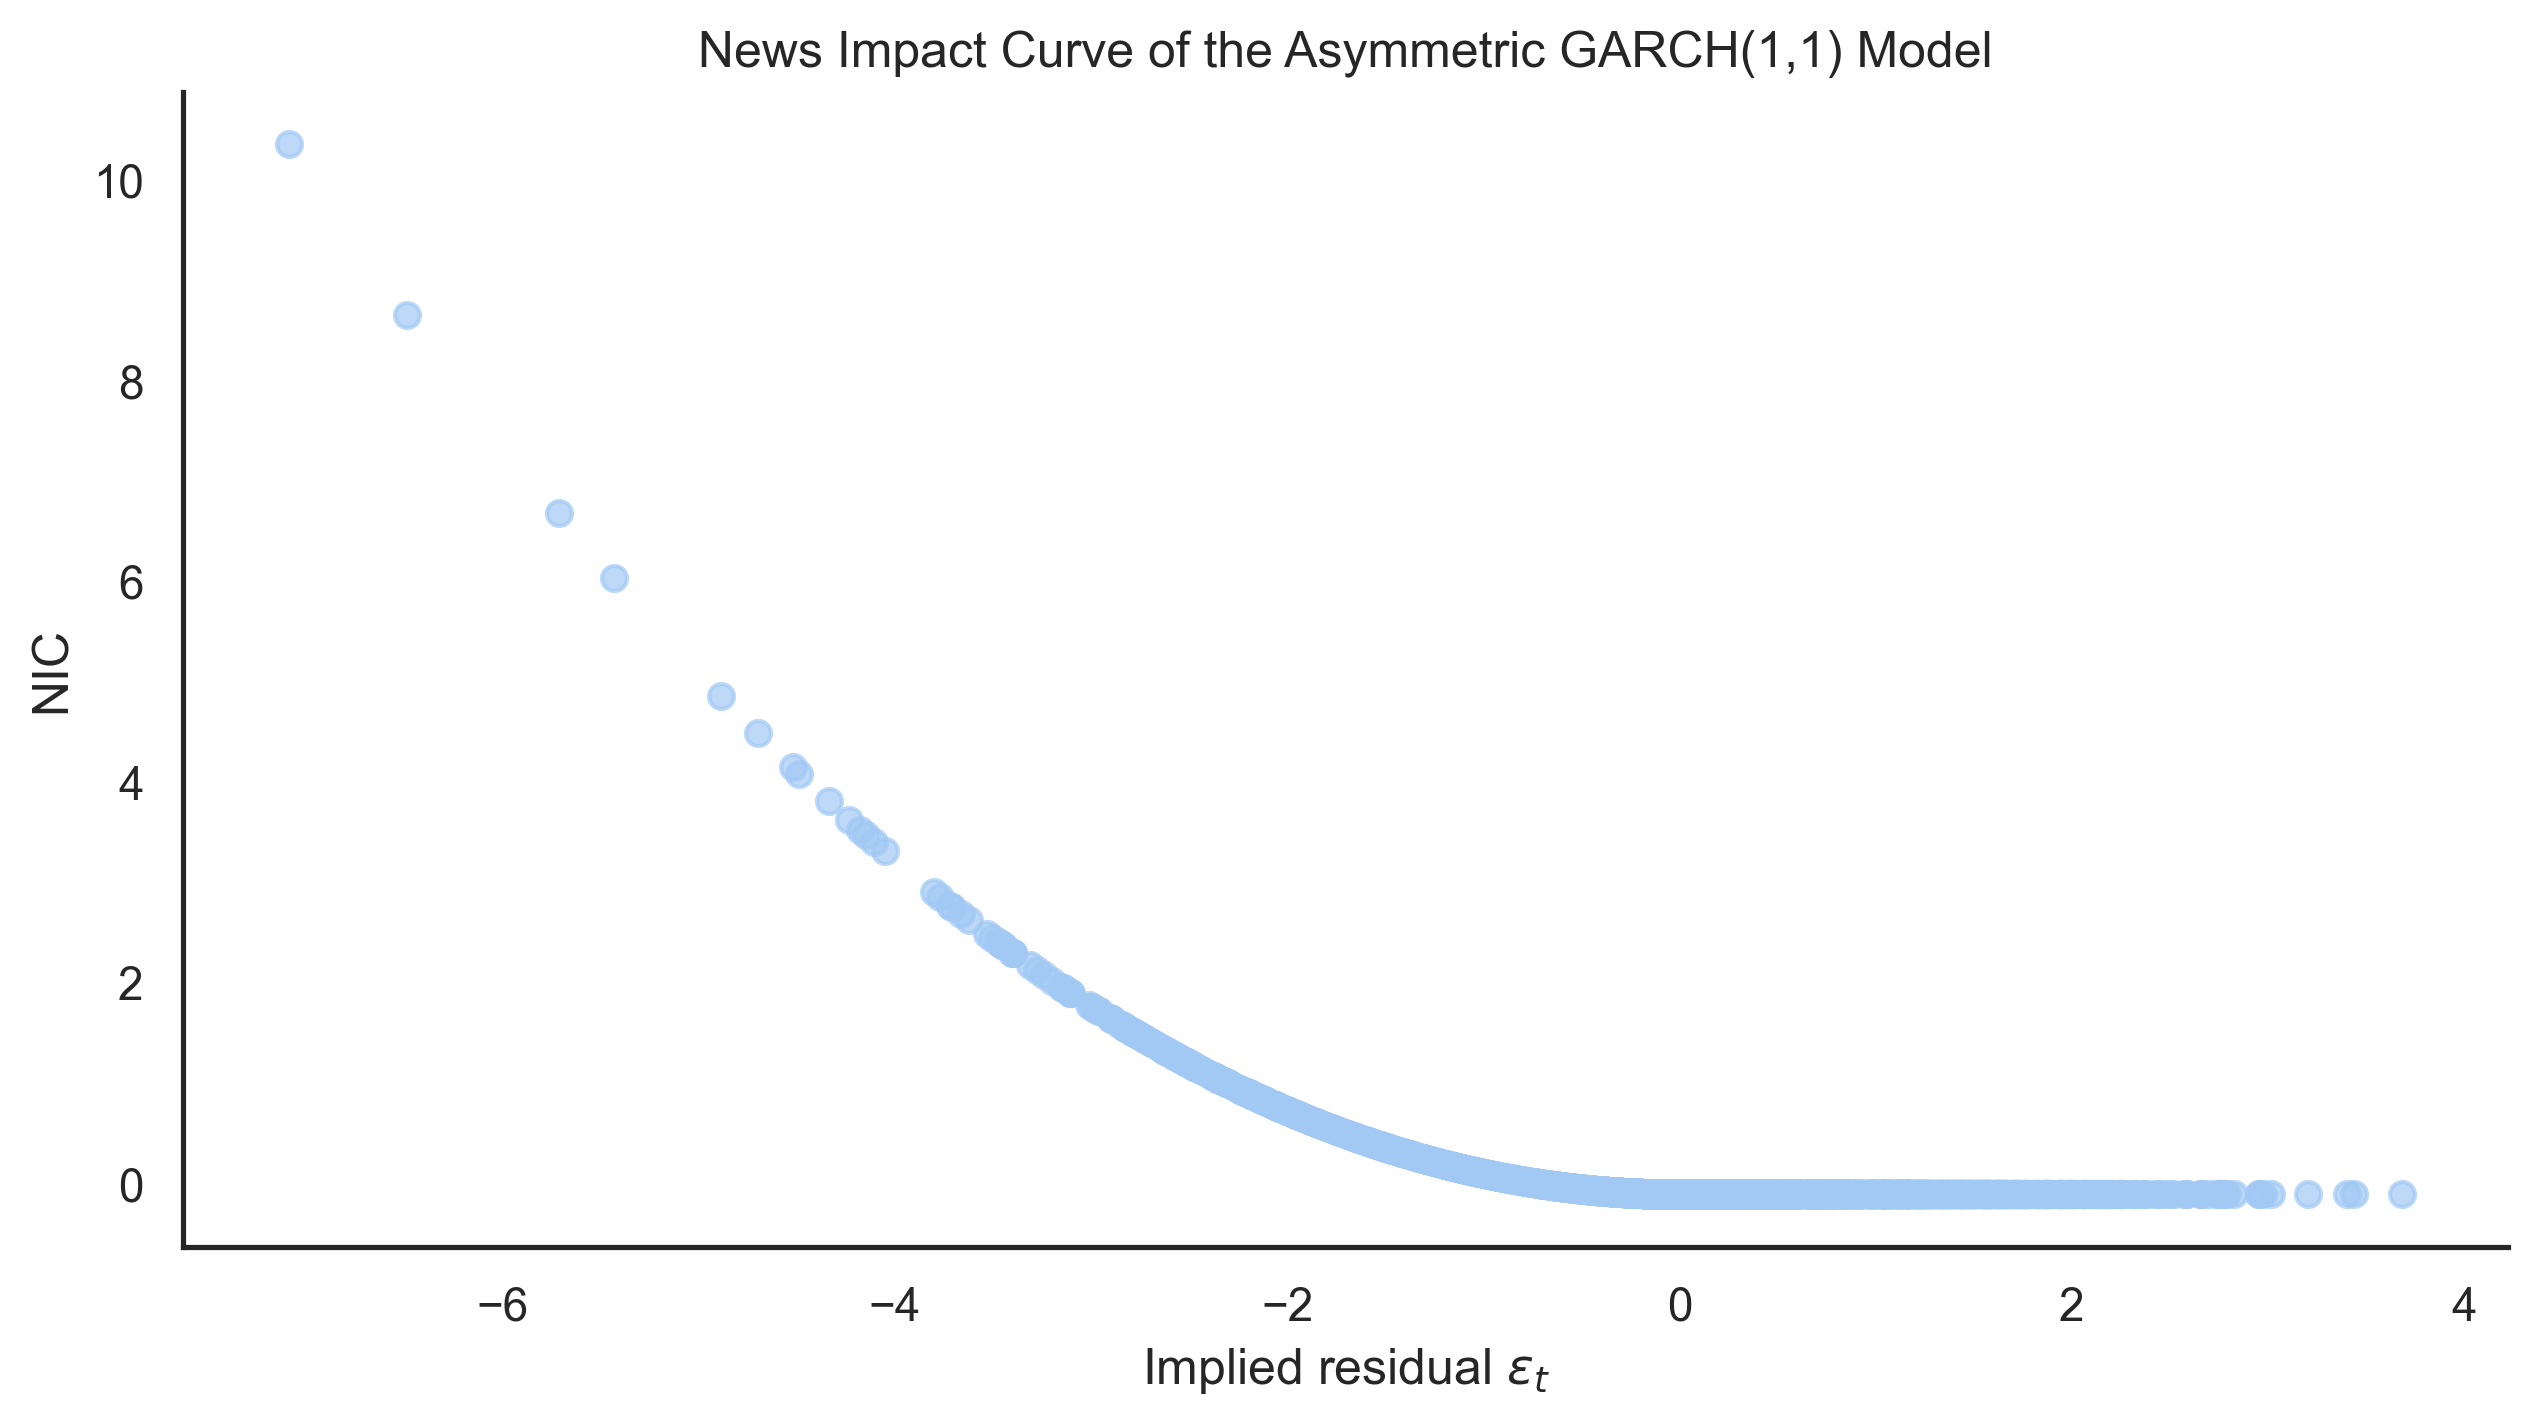

In [5]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('Asymmetric GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigmasquared = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)

plot_results(dates, returns, sigmasquared, 'Asymmetric GARCH')

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu          : {mu_hat:.3f}")
print(f"  omega       : {omega_hat:.3f}")
print(f"  alpha_pos   : {alpha_hat_pos:.3f}")
print(f"  alpha_neg   : {alpha_hat_neg:.3f}")
print(f"  beta        : {beta_hat:.3f}")
print(f"  nu          : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'Asymmetric GARCH(1,1) Model')

# Symmetric Beta-t-GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:78: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(negative_log_likelihood, initial_values, args=(returns, model_type), bounds=bounds, method='Nelder-Mead')


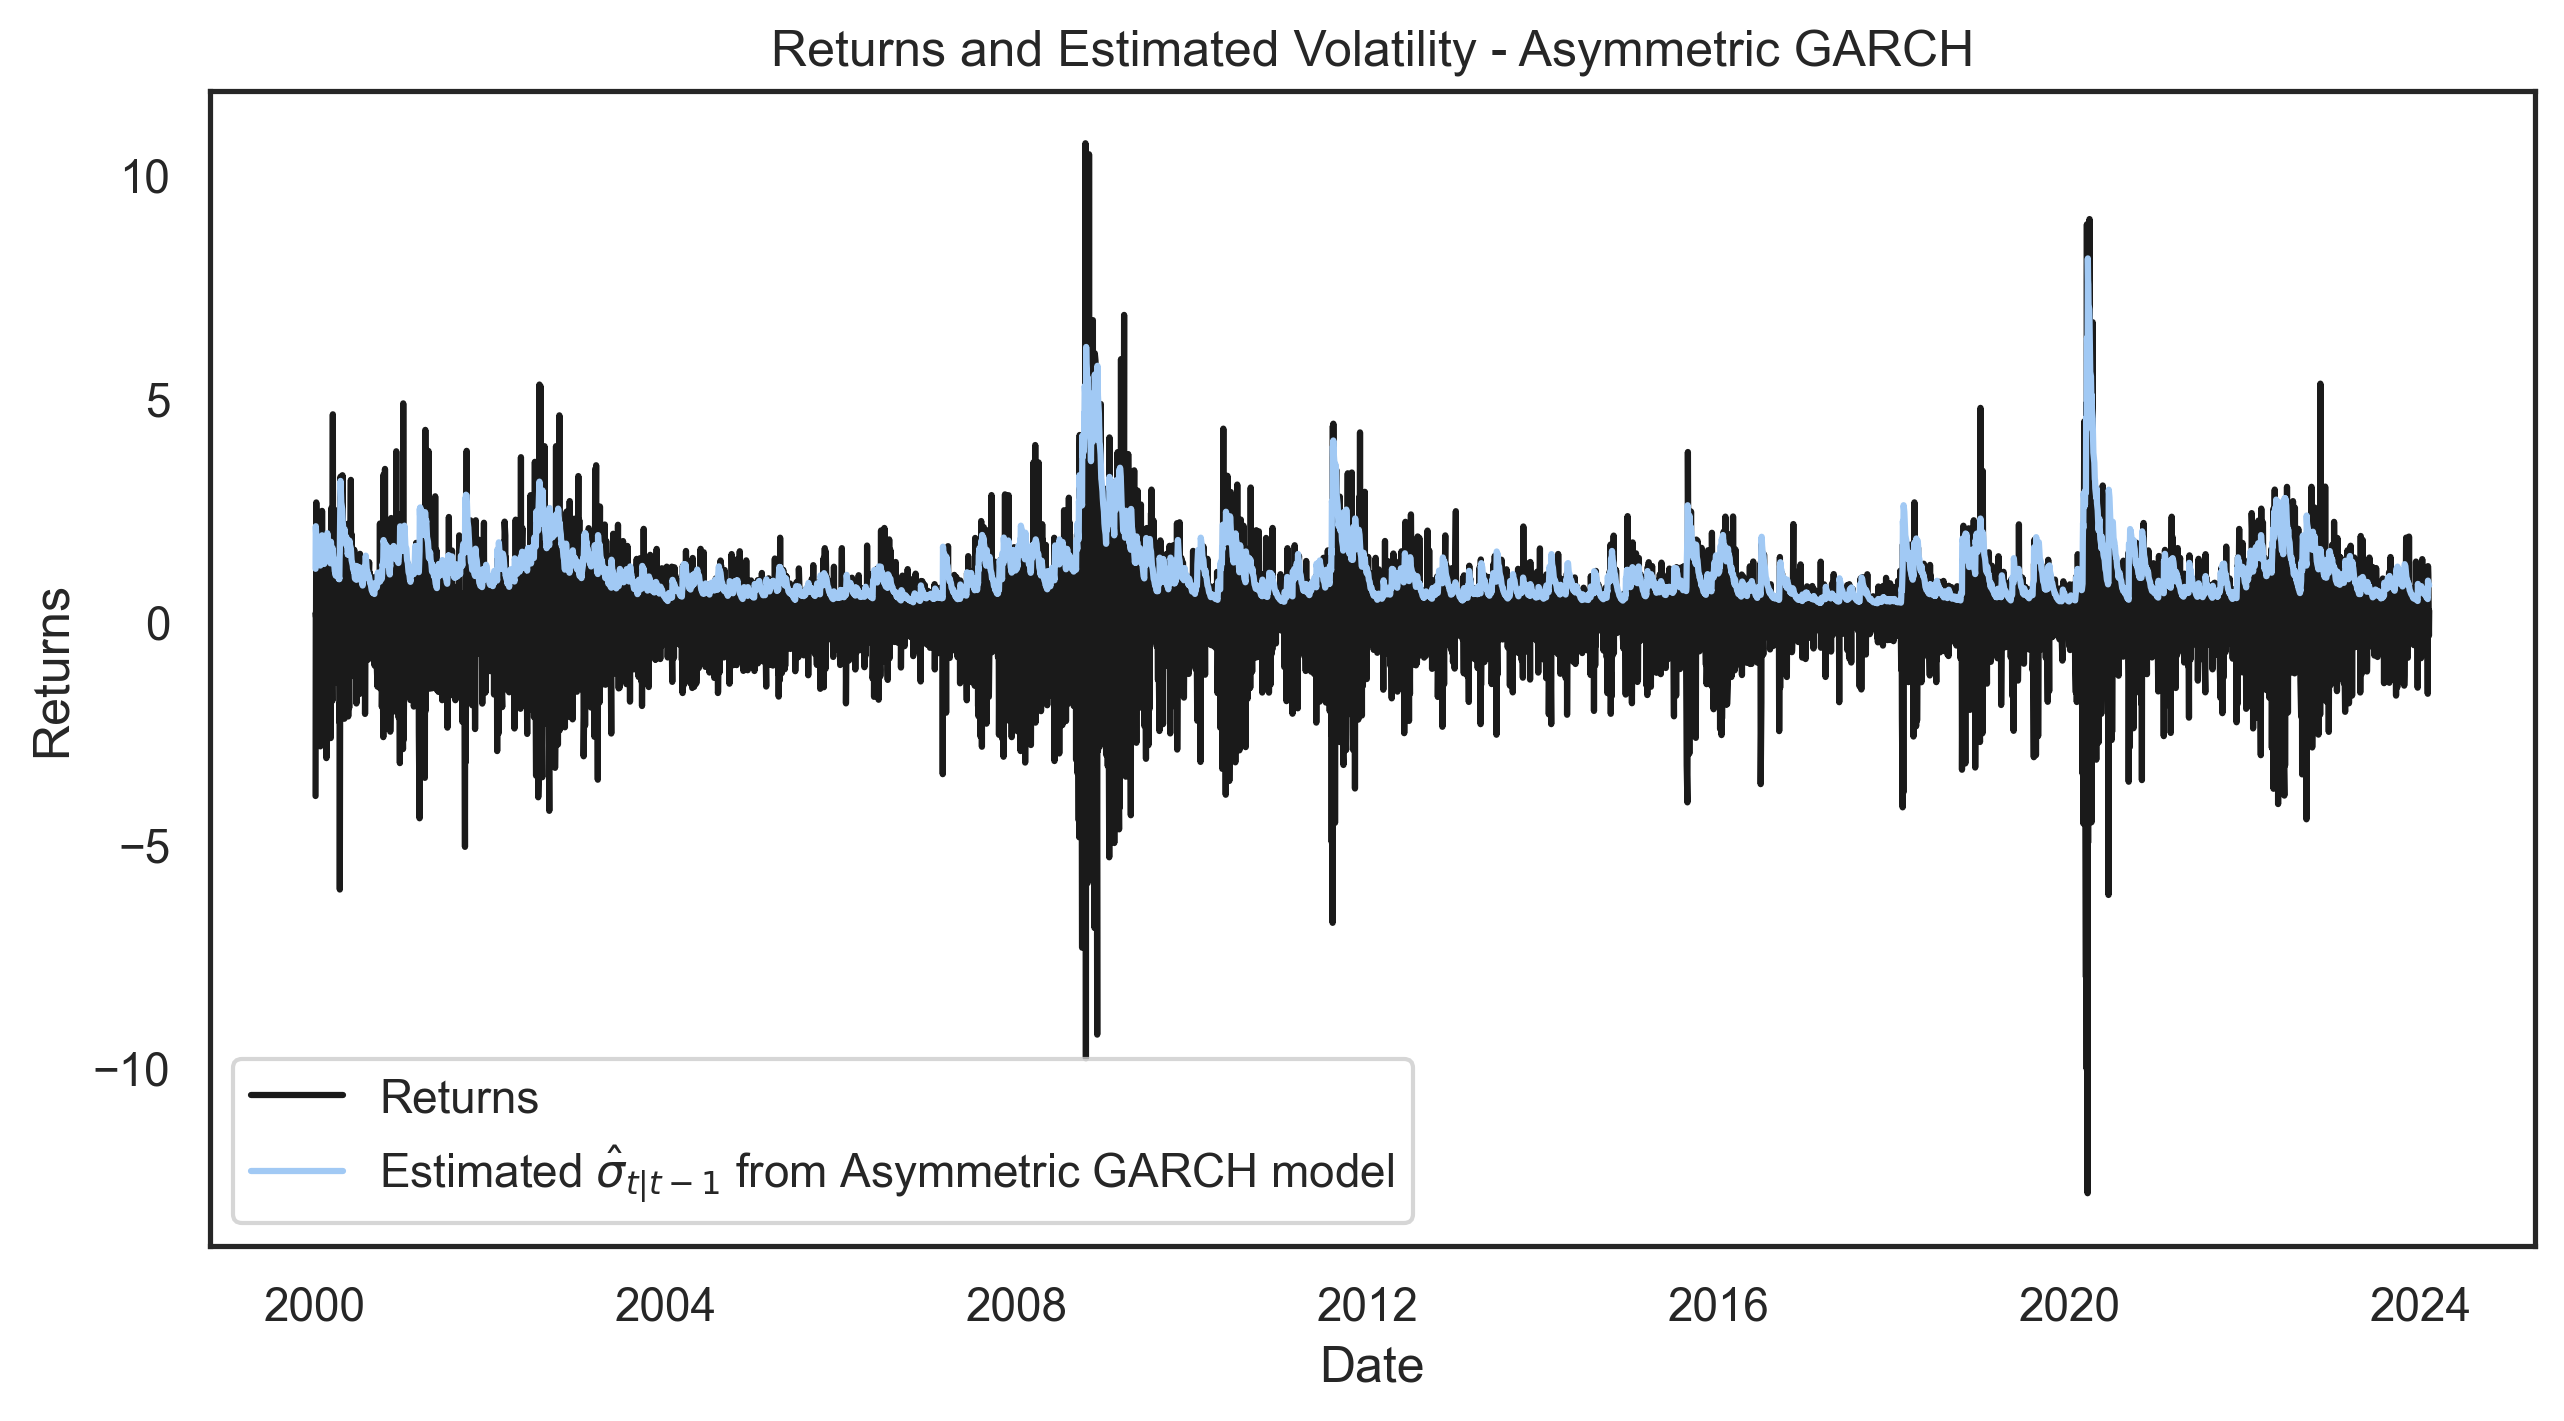

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.076
  lam    : 0.000
  phi    : 0.983
  kappa  : 0.080
  k_tilde: 0.000
  nu     : 7.178
Log-Likelihood: -8228.8


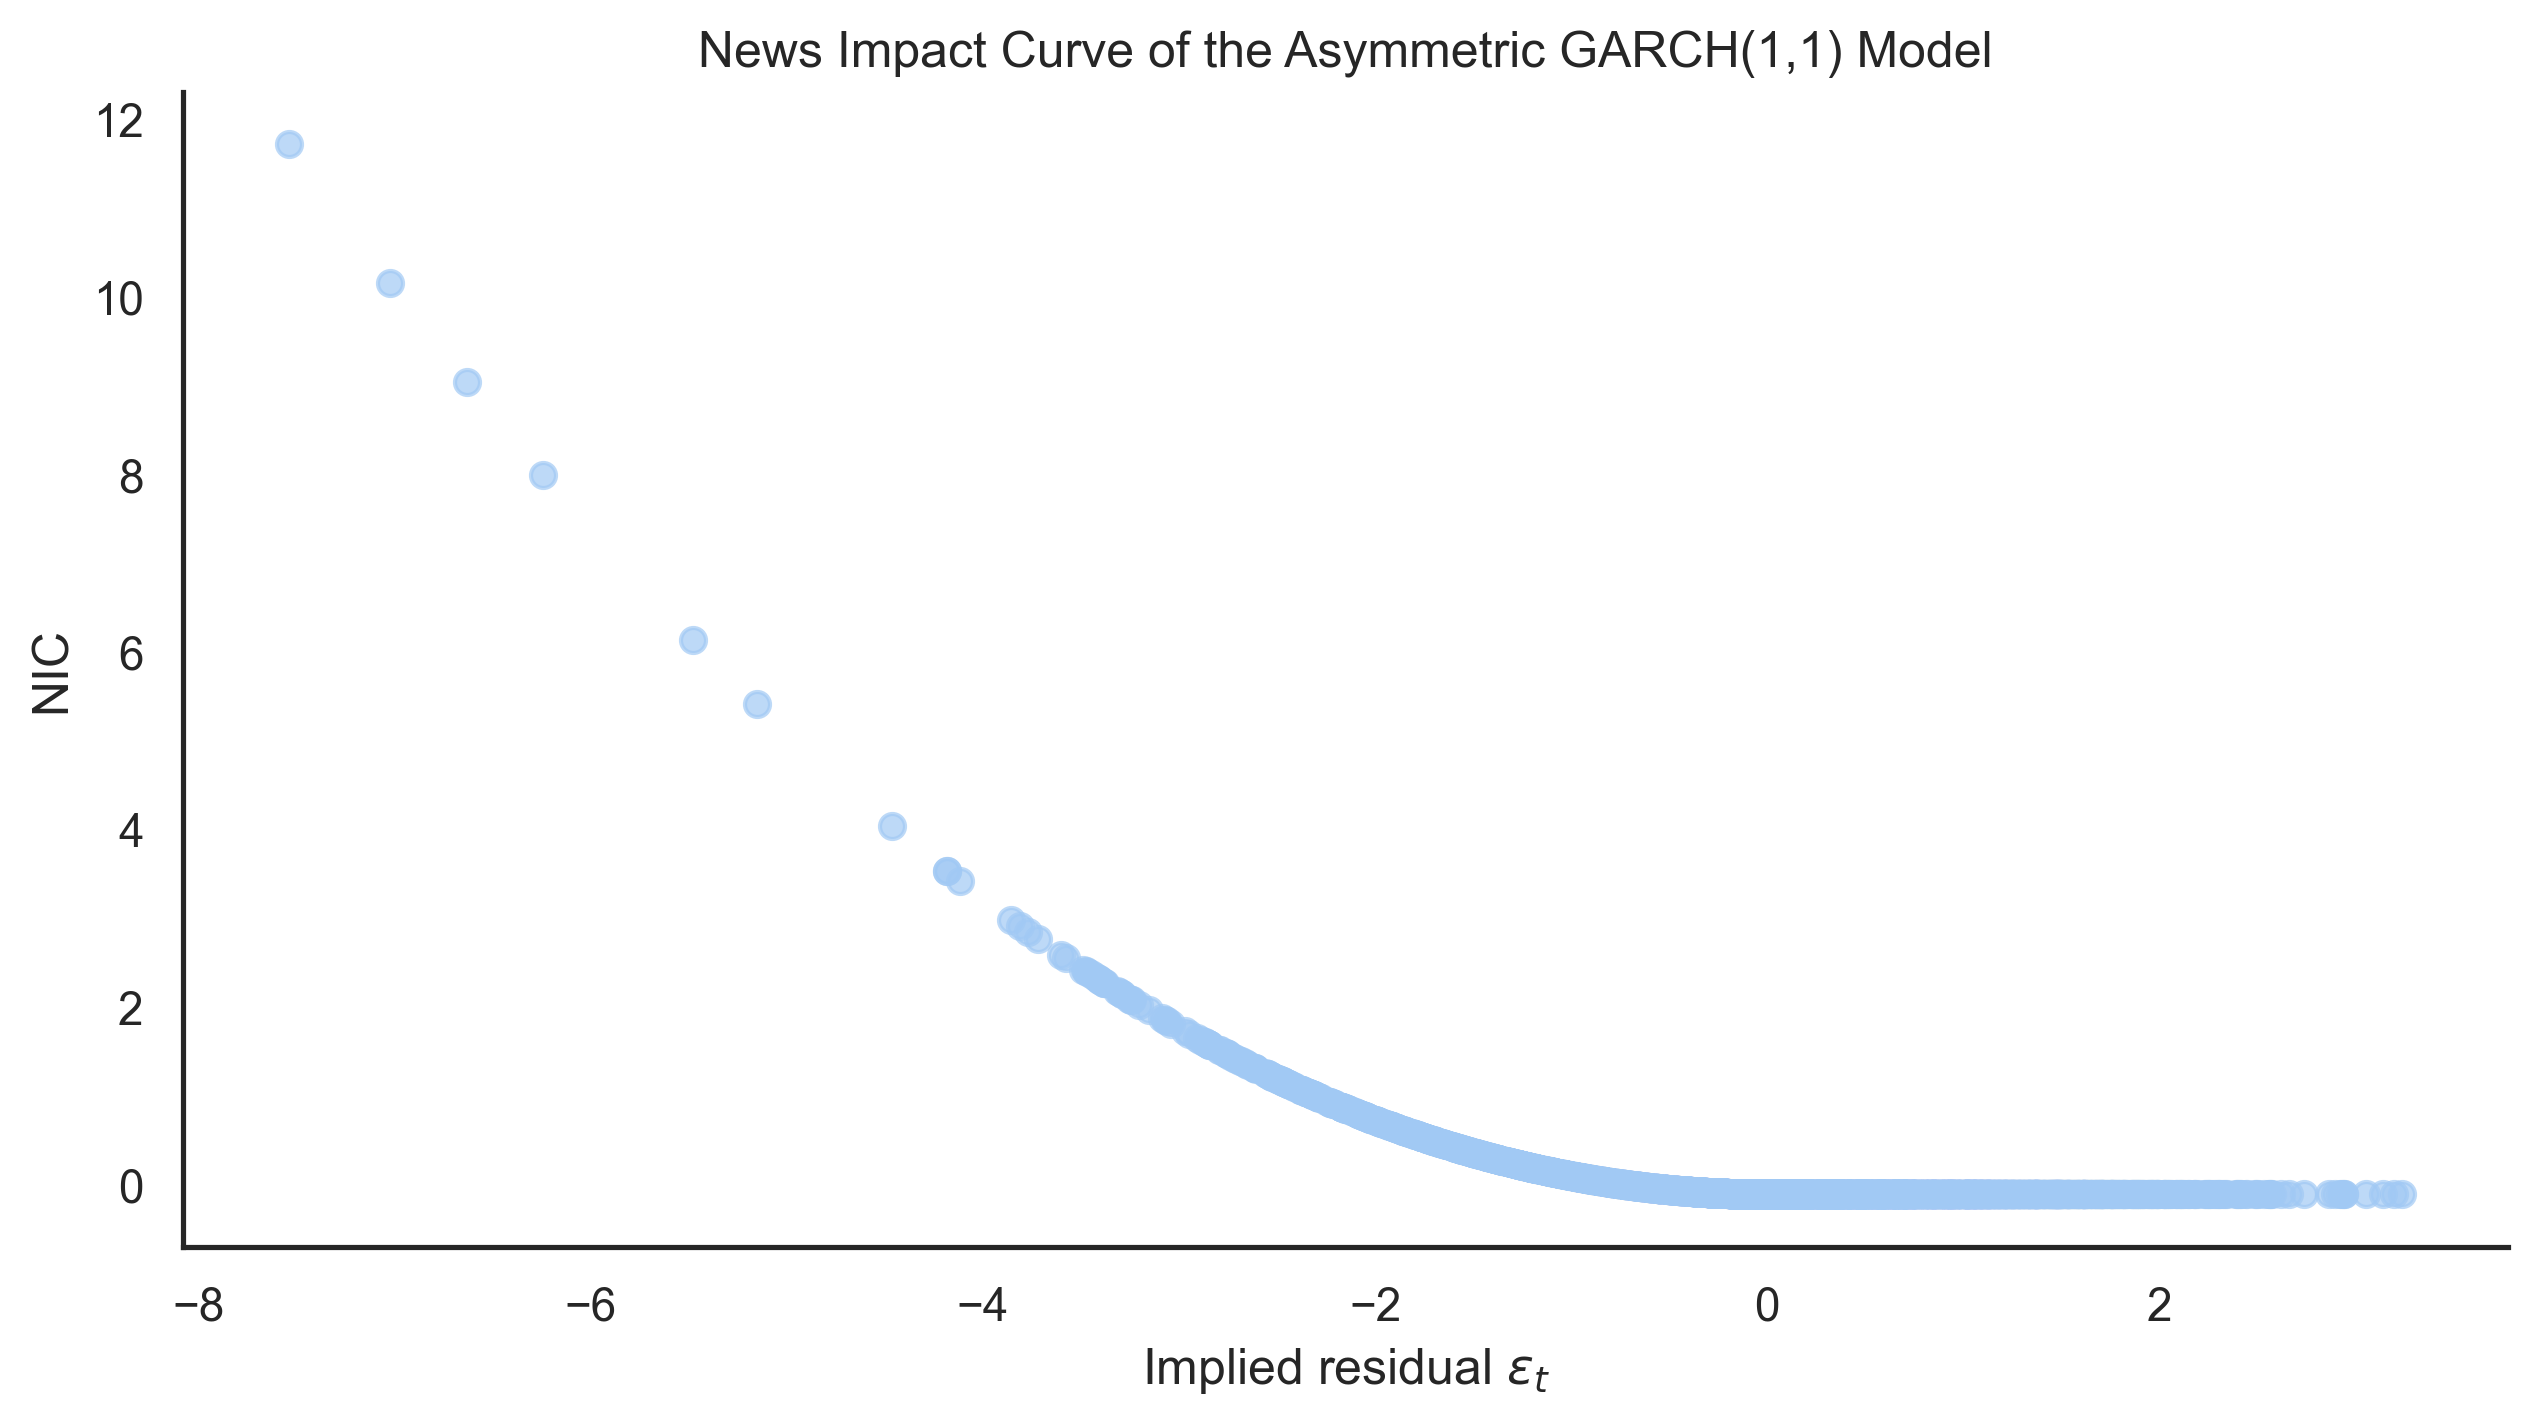

In [6]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (0, 0), (2, 40)] # Constrain kappa_tilde = 0
result = optimize_model('Symmetric Beta-t-GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)

plot_results(dates, returns, sigma_squared, 'Asymmetric GARCH')

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

conditional_var = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'Asymmetric GARCH(1,1) Model')

# Asymmetric Beta-t-EGARCH,

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:48: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_14906/3498811592.py:53: RuntimeWarning: overflow encountered in square
  return sigma**2, u, v


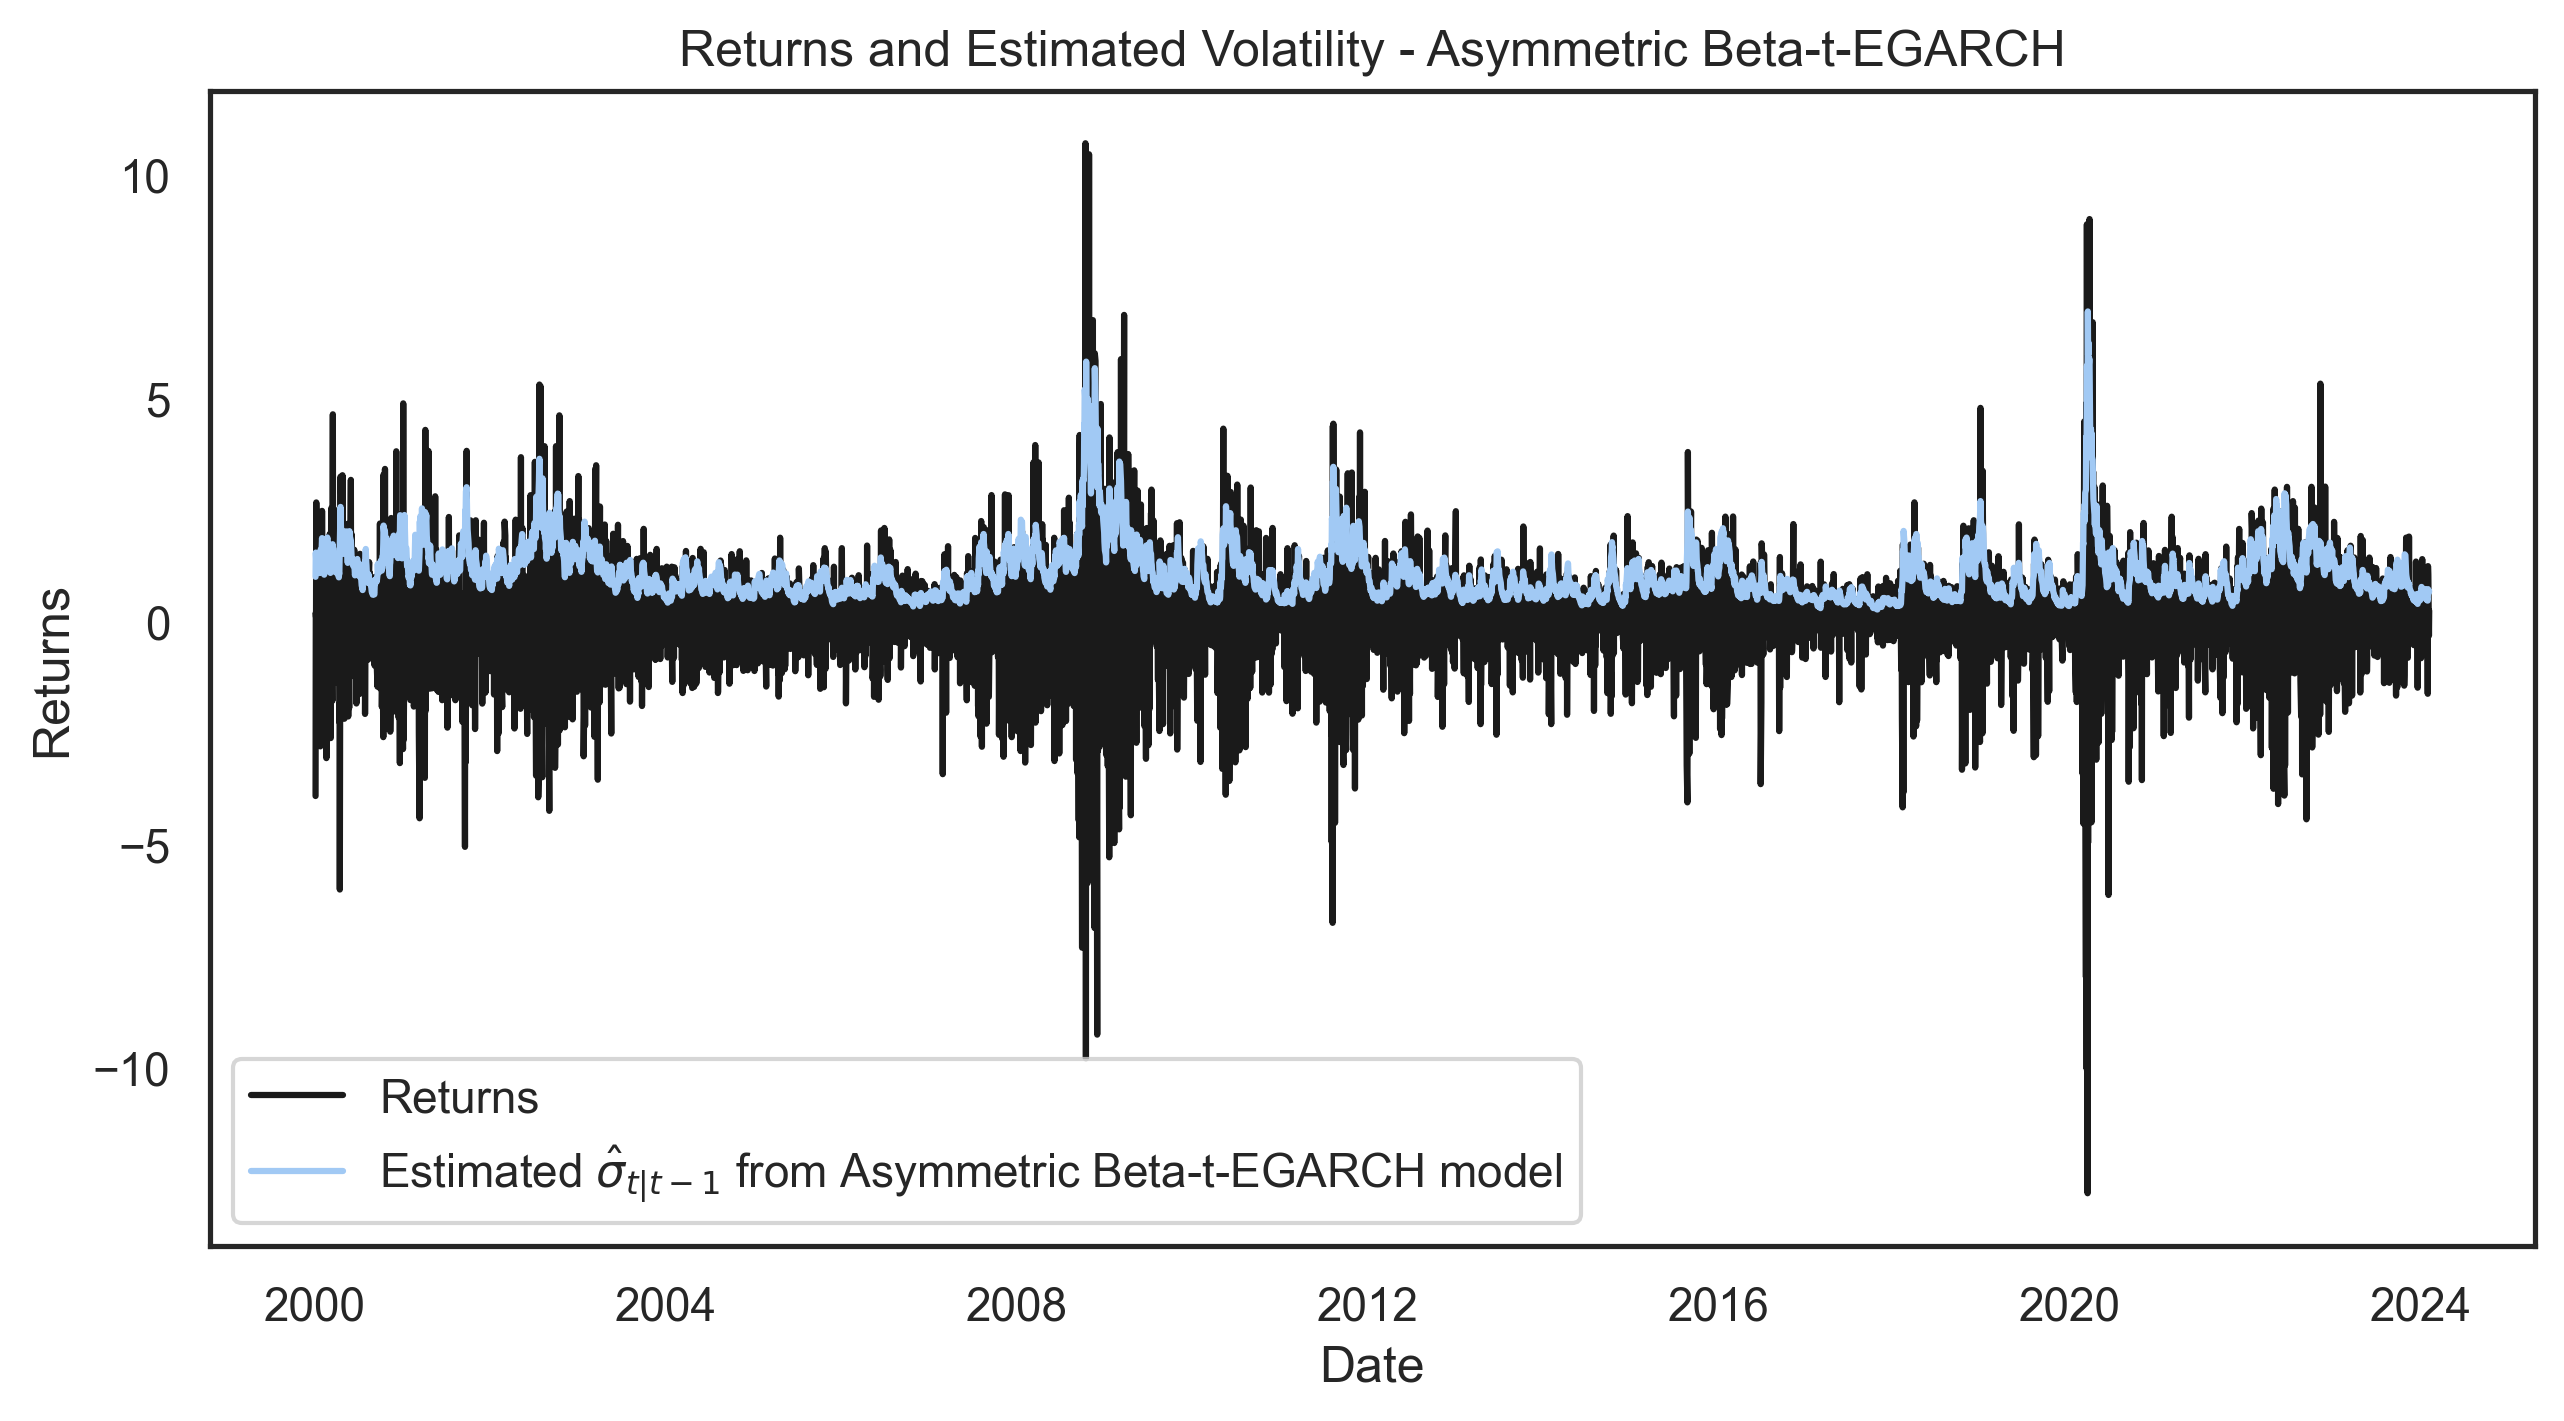

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.033
  lam    : 0.001
  phi    : 0.974
  kappa  : 0.061
  k_tilde: -0.034
  nu     : 8.439
Log-Likelihood: -8088.7


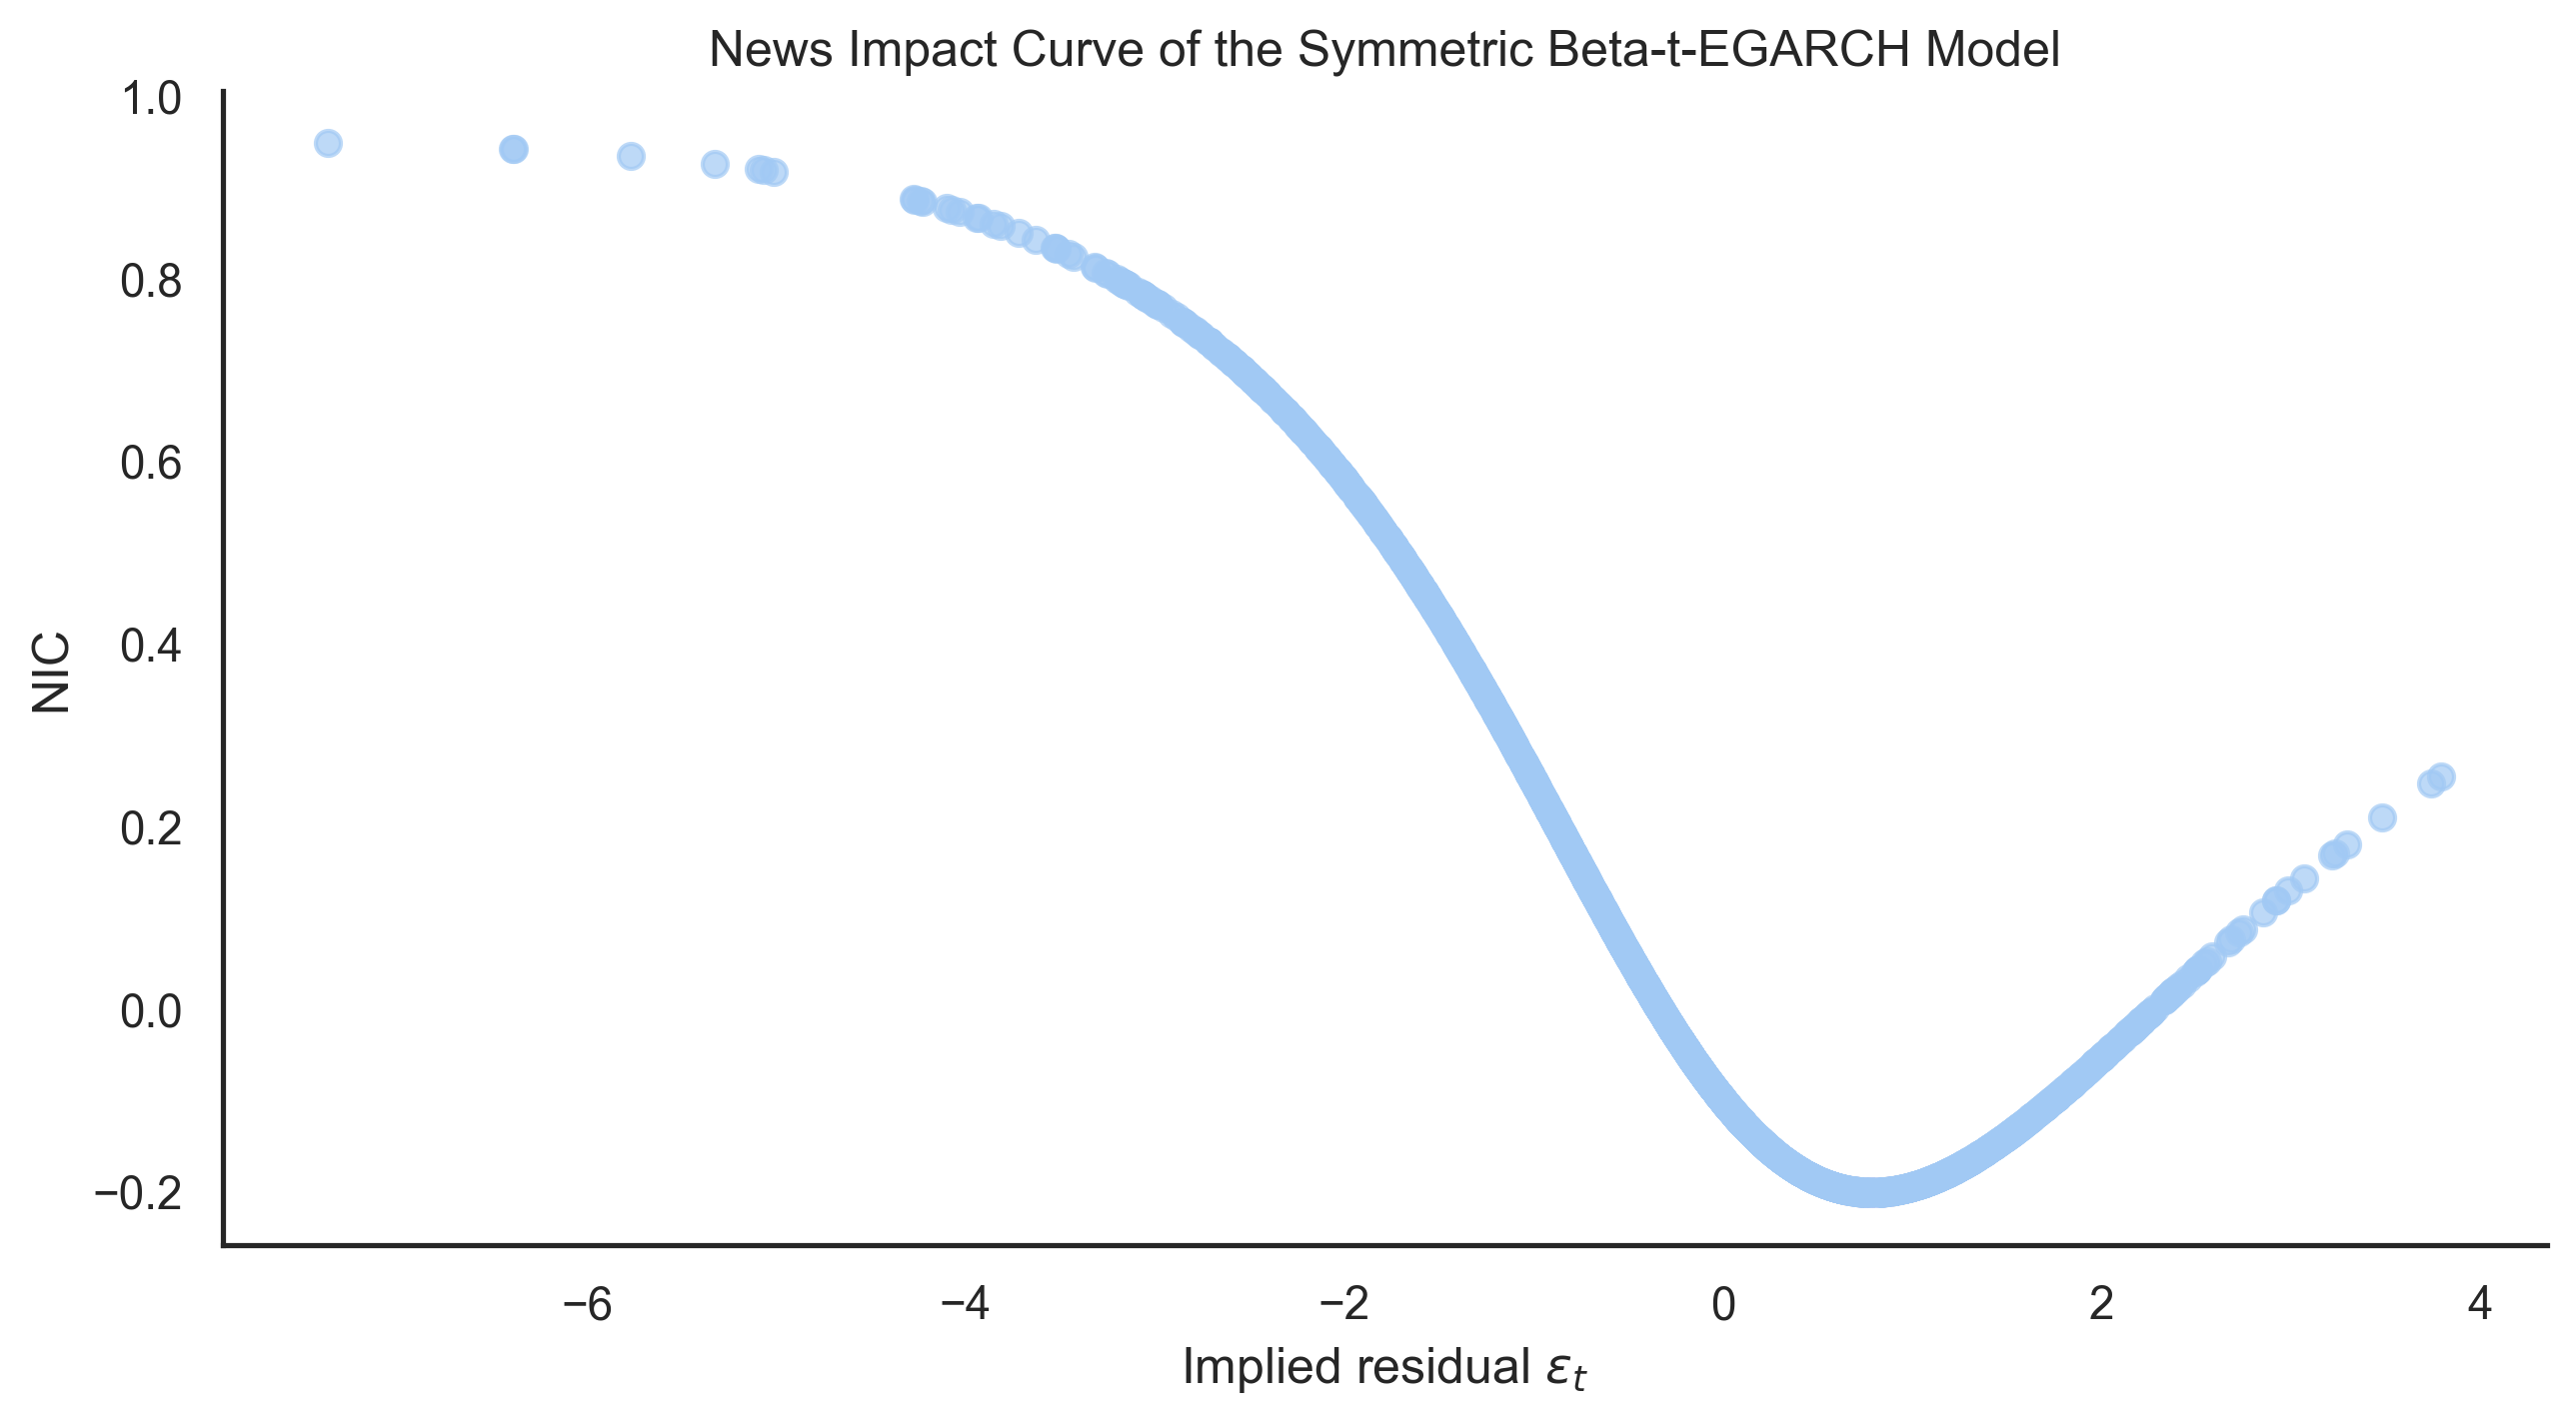

In [7]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
result = optimize_model('Beta-t-GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch(result.x, returns)

plot_results(dates, returns, conditional_var, 'Asymmetric Beta-t-EGARCH')

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

nic = 2 * kappa_hat * u + 2 * k_tilde_hat * v
plot_nic((returns - mu_hat) / np.sqrt(conditional_var), nic, 'Symmetric Beta-t-EGARCH Model')